# Laplace on MNIST

## Setup data and model and train it

We start the tutorial by downloading and setting up a dataloader for `MNIST`. We will use a simple `flax.nnx` model for the training. The data + model setup and training closely follows the `flax.nnx` [documentation](https://flax.readthedocs.io/en/latest/mnist_tutorial.html) to stress the flexible post-hoc abilities of `laplax` (and, of course, Laplace Approximations in general).

In [9]:
from itertools import islice

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set the random seed for reproducibility
torch.manual_seed(0)

# Define constants
train_steps = 2200
eval_every = 200
train_batch_size = 32
val_batch_size = 32

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Load MNIST datasets
train_dataset = datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

test_dataset = datasets.MNIST(
    root="data", train=False, download=True, transform=transform
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4,
    prefetch_factor=2,
    persistent_workers=True,
    pin_memory=torch.cuda.is_available(),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=val_batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=4,
    prefetch_factor=2,
    persistent_workers=True,
    pin_memory=torch.cuda.is_available(),
)


def format_batch(batch):
    return {"input": batch[0].permute(0, 2, 3, 1).numpy(), "target": batch[1].numpy()}


def get_infinite_train_iter():
    """Creates an infinite iterator over the training data."""
    while True:
        for batch in train_loader:
            yield format_batch(batch)


# Create training iterator that yields for exactly train_steps
train_iter = islice(get_infinite_train_iter(), train_steps)
num_training_samples = len(train_dataset)


# For the test dataset
def get_test_iter(loader):
    for batch in loader:
        yield format_batch(batch)

/home/t/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/t/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [10]:
from functools import partial

import jax
from flax import nnx


class CNN(nnx.Module):
    """A simple CNN model."""

    def __init__(self, *, rngs: nnx.Rngs):
        self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), padding="VALID", rngs=rngs)
        self.conv2 = nnx.Conv(32, 32, kernel_size=(3, 3), padding="VALID", rngs=rngs)
        self.conv3 = nnx.Conv(32, 64, kernel_size=(3, 3), padding="VALID", rngs=rngs)
        self.avg_pool1 = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
        self.avg_pool2 = partial(nnx.avg_pool, window_shape=(3, 3), strides=(1, 1))
        self.linear1 = nnx.Linear(64, 10, rngs=rngs)

    def __call__(self, x):
        x = self.avg_pool1(nnx.relu(self.conv1(x)))
        x = self.avg_pool1(nnx.relu(self.conv2(x)))
        x = self.avg_pool2(nnx.relu(self.conv3(x)))
        x = x.flatten()
        x = self.linear1(x)
        return x


# Instantiate the model
model = CNN(rngs=nnx.Rngs(0))


# Create forward function with vmap
@nnx.vmap(in_axes=(None, 0), out_axes=0)
def forward(model: CNN, x):
    return model(x)


# Visualize it
# nnx.display(model)

### Setup optimizer

In [11]:
import optax

learning_rate = 3e-4
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average("loss"),
)

### Setup training step functions

In [12]:
def loss_fn(model: CNN, batch):
    logits = forward(model, batch["input"])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch["target"]
    ).mean()
    return loss, logits


@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch["target"])  # In-place updates
    optimizer.update(grads)  # In-place updates


@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch["target"])  # In-place updates

### Training the model

In [13]:
metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
}

for step, batch in enumerate(train_iter):
    # Run the optimization for one step and make a stateful update to the following:
    # - The train state's model parameters
    # - The optimizer state
    # - The training loss and accuracy batch metrics
    train_step(model, optimizer, metrics, batch)

    if step > 0 and (step % eval_every == 0 or step == train_steps - 1):
        # One training epoch has passed.
        # Log the training metrics.
        for metric, value in metrics.compute().items():  # Compute the metrics.
            metrics_history[f"train_{metric}"].append(value)  # Record the metrics.
        metrics.reset()  # Reset the metrics for the test set.

        # Compute the metrics on the test set after each training epoch.
        for test_batch in get_test_iter(test_loader):
            eval_step(model, metrics, test_batch)

        # Log the test metrics.
        for metric, value in metrics.compute().items():
            metrics_history[f"test_{metric}"].append(value)
        metrics.reset()  # Reset the metrics for the next training epoch.

        print(
            f"[train] step: {step}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
        )
        print(
            f"[test] step: {step}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
        )

/home/t/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/home/t/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[train] step: 200, loss: 1.6962909698486328, accuracy: 50.342041015625
[test] step: 200, loss: 0.9235506653785706, accuracy: 75.51081848144531
[train] step: 400, loss: 0.667319118976593, accuracy: 82.1875
[test] step: 400, loss: 0.4883890450000763, accuracy: 86.75881958007812
[train] step: 600, loss: 0.425566166639328, accuracy: 88.296875
[test] step: 600, loss: 0.35399001836776733, accuracy: 89.66346740722656
[train] step: 800, loss: 0.35134345293045044, accuracy: 89.703125
[test] step: 800, loss: 0.2834475636482239, accuracy: 92.13742065429688
[train] step: 1000, loss: 0.3066498637199402, accuracy: 91.9375
[test] step: 1000, loss: 0.2640306055545807, accuracy: 92.33773803710938
[train] step: 1200, loss: 0.2795772850513458, accuracy: 91.99999237060547
[test] step: 1200, loss: 0.24396412074565887, accuracy: 92.7784423828125
[train] step: 1400, loss: 0.23551706969738007, accuracy: 93.125
[test] step: 1400, loss: 0.20762695372104645, accuracy: 93.96034240722656
[train] step: 1600, loss: 

## Check model calibration

So far, we have followed along the standard MNIST tutorial from `flax.nnx`. Now, we want to check the calibration of the model, i.e. whether the probabilities it assigns to each class label represents its confidence. A good score for this is the ECE (see e.g. [Mucsányi2023](https://trustworthyml.io/)).

Accuracy: 0.9443


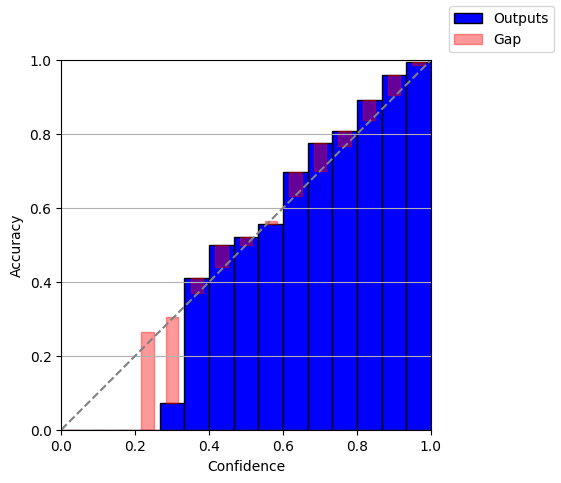

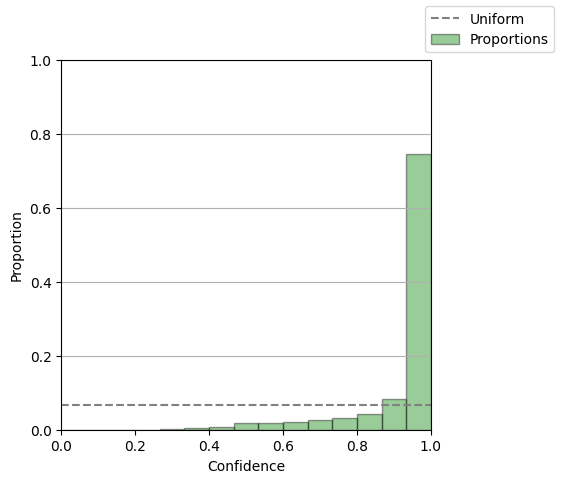

In [14]:
%matplotlib inline
import jax.numpy as jnp
from plotting import create_proportion_diagram, create_reliability_diagram

from laplax.eval.metrics import calculate_bin_metrics, correctness

NUM_BINS = 15

# Collect predictions and targets from test dataset
all_predictions = []
all_targets = []


for batch in get_test_iter(test_loader):
    # Get predictions for this batch
    predictions = jax.nn.softmax(forward(model, batch["input"]), axis=1)
    all_predictions.append(predictions)
    all_targets.append(batch["target"])


# Concatenate all batches
predictions = jnp.concatenate(all_predictions, axis=0)
targets = jnp.concatenate(all_targets, axis=0)

# Calculate confidence and correctness
max_prob = predictions.max(axis=-1)
correctness_float = correctness(pred=predictions, target=targets).astype(jnp.float32)

print(f"Accuracy: {correctness_float.mean():.4f}")

# Calculate bin metrics
bin_proportions, bin_confidences, bin_accuracies = calculate_bin_metrics(
    confidence=max_prob, correctness=correctness_float, num_bins=NUM_BINS
)

# Plot the reliability diagram
create_reliability_diagram(
    bin_confidences=bin_confidences,
    bin_accuracies=bin_accuracies,
    num_bins=NUM_BINS,
)

# Plot the proportion diagram
create_proportion_diagram(
    bin_proportions=bin_proportions,
    num_bins=NUM_BINS,
)

## Apply Laplace Approximation

First, we create the GGN matrix-vector product. As the GGN has 679,730,993,764 entries in this case, the naive representation of the dense matrix would take approximately 2.718 TB of VRAM. Therefore, it is crucial to represent this matrix-vector product _implicitly_, as shown below.

In [15]:
from laplax.curv import create_ggn_mv

# Create GGN
graph_def, params = nnx.split(model)


def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]


train_batch = next(get_infinite_train_iter())
ggn_mv = create_ggn_mv(
    model_fn,
    params,
    train_batch,
    loss_fn="cross_entropy",
    num_total_samples=num_training_samples,
)

Next, we use the GGN matrix-vector product above to obtain a low-rank approximation of the GGN. Even though the dense GGN cannot be represented in memory, its low-rank approximation for a sufficiently low rank remains tractable to hold in memory. Having access to the low-rank GGN terms, we can then efficiently invert an isotropically dampened version of it which is the weight-space covariance matrix of our Laplace approximation.

In [16]:
from laplax.curv.cov import create_posterior_fn

# Create Posterior
posterior_fn = create_posterior_fn(
    "low_rank",
    mv=ggn_mv,
    layout=params,
    key=jax.random.key(20),
    maxiter=20,
    mv_jittable=True,
)

Finally, we need a way to represent the model's uncertainty in its output space, as decisions (such as abstaining from prediction) are made based on the model output, not on the weight space.

MAP ECE: 0.0179
MAP acc: 0.9442
Laplace ECE: 0.0198
Laplace acc: 0.9443


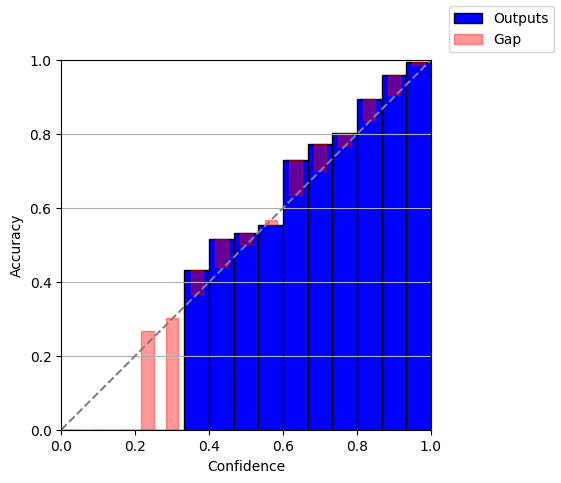

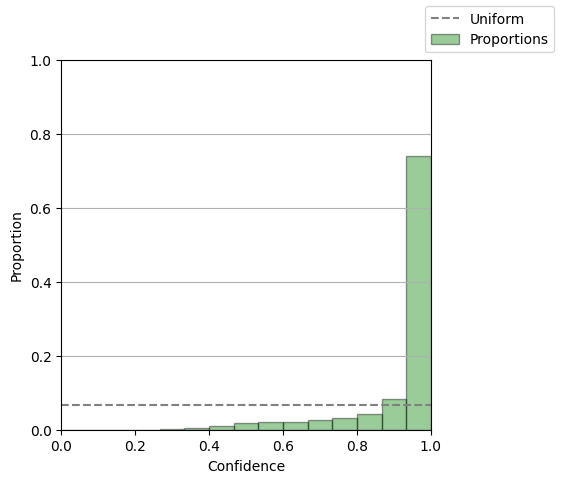

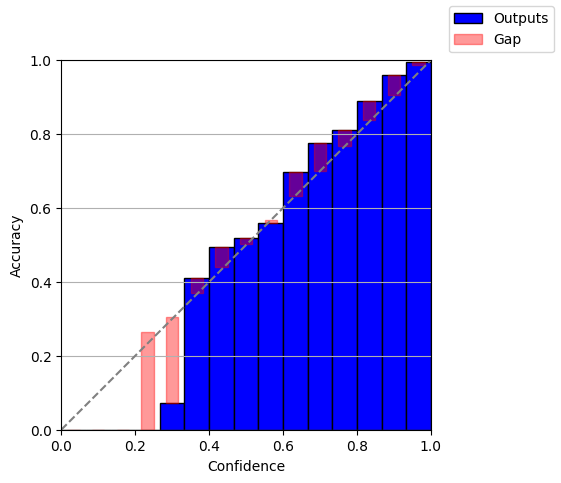

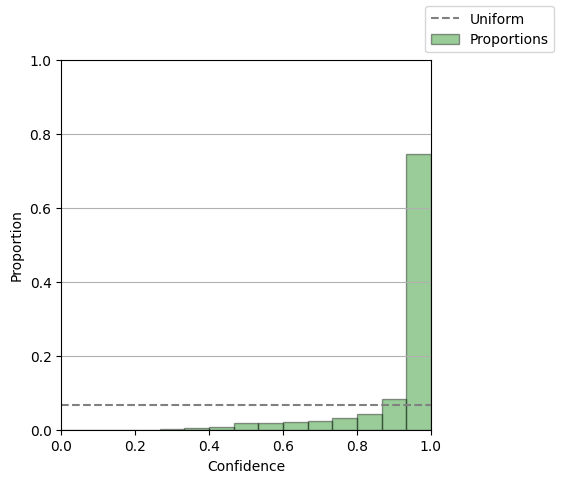

In [18]:
from laplax.eval.metrics import expected_calibration_error
from laplax.eval.pushforward import (
    lin_mc_pred_act,
    lin_pred_mean,
    lin_setup,
    set_lin_pushforward,
)

prior_arguments = {"prior_prec": 10000.0}
pushforward_fns = [
    lin_setup,
    lin_pred_mean,
    lin_mc_pred_act,
]

pushforward_fn = jax.jit(jax.vmap(
    set_lin_pushforward(
        model_fn=model_fn,
        mean_params=params,
        posterior_fn=posterior_fn,
        prior_arguments=prior_arguments,
        pushforward_fns=pushforward_fns,
        key=jax.random.key(0),
        num_samples=30,
    )
))

confidences_map = []
correctnesses_map = []
confidences_pred = []
correctnesses_pred = []

n_batches = len(test_loader)
# std_mean = 0


pushforward_fn = jax.jit(jax.vmap(
    set_lin_pushforward(
        model_fn=model_fn,
        mean_params=params,
        posterior_fn=posterior_fn,
        prior_arguments=prior_arguments,
        pushforward_fns=pushforward_fns,
        key=jax.random.key(0),
        num_samples=30,
    )
))

confidences_map = []
correctnesses_map = []
confidences_pred = []
correctnesses_pred = []

n_batches = len(test_loader)

for i, batch in enumerate(get_test_iter(test_loader)):
    print(f"{i + 1}/{n_batches}", end="\r")
    results = pushforward_fn(batch["input"])
    target = batch["target"]
    map_ = results["map"]
    pred_act = results["mc_pred_act"]

    # std_mean = (i * std_mean + jnp.mean(jnp.sqrt(results["pred_var"]))) / (i + 1)

    confidences_map.append(jnp.max(jax.nn.softmax(map_, axis=1), axis=1))
    correctnesses_map.append(correctness(pred=map_, target=target).astype(jnp.float32))
    confidences_pred.append(jnp.max(pred_act, axis=1))
    correctnesses_pred.append(
        correctness(pred=pred_act, target=target).astype(jnp.float32)
    )

confidences_map = jnp.concatenate(confidences_map, axis=0)
correctnesses_map = jnp.concatenate(correctnesses_map, axis=0)
confidences_pred = jnp.concatenate(confidences_pred, axis=0)
correctnesses_pred = jnp.concatenate(correctnesses_pred, axis=0)

ece_map = expected_calibration_error(
    confidence=confidences_map, correctness=correctnesses_map, num_bins=NUM_BINS
)
ece_pred = expected_calibration_error(
    confidence=confidences_pred, correctness=correctnesses_pred, num_bins=NUM_BINS
)

print(f"MAP ECE: {ece_map:.4f}")
print(f"MAP acc: {correctnesses_map.mean():.4f}")
print(f"Laplace ECE: {ece_pred:.4f}")
print(f"Laplace acc: {correctnesses_pred.mean():.4f}")
# print(f"Laplace std mean: {std_mean:.4f}")


# Calculate bin metrics for Laplace
bin_proportions_pred, bin_confidences_pred, bin_accuracies_pred = calculate_bin_metrics(
    confidence=confidences_pred, correctness=correctnesses_pred, num_bins=NUM_BINS
)

# Plot the reliability diagram
create_reliability_diagram(
    bin_confidences=bin_confidences_pred,
    bin_accuracies=bin_accuracies_pred,
    num_bins=NUM_BINS,
)

# Plot the proportion diagram
create_proportion_diagram(
    bin_proportions=bin_proportions_pred,
    num_bins=NUM_BINS,
)

# Calculate bin metrics for MAP
bin_proportions_map, bin_confidences_map, bin_accuracies_map = calculate_bin_metrics(
    confidence=confidences_map, correctness=correctnesses_map, num_bins=NUM_BINS
)

# Plot the reliability diagram
create_reliability_diagram(
    bin_confidences=bin_confidences_map,
    bin_accuracies=bin_accuracies_map,
    num_bins=NUM_BINS,
)

# Plot the proportion diagram
create_proportion_diagram(
    bin_proportions=bin_proportions_map,
    num_bins=NUM_BINS,
)

## Same evaluation using the Metrics API

MAP ECE: 0.0179
MAP acc: 0.9442
Laplace ECE: 0.0198
Laplace acc: 0.9443


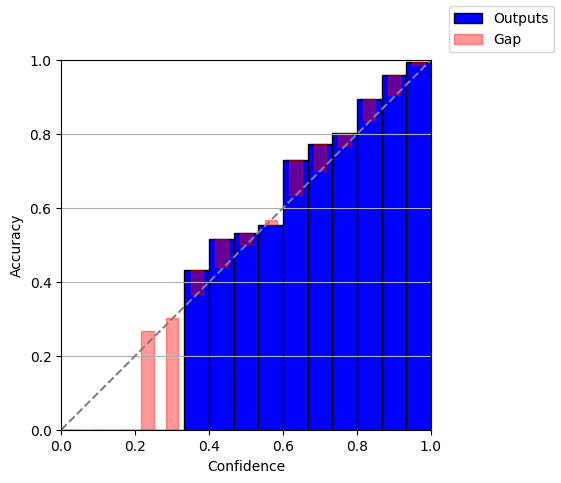

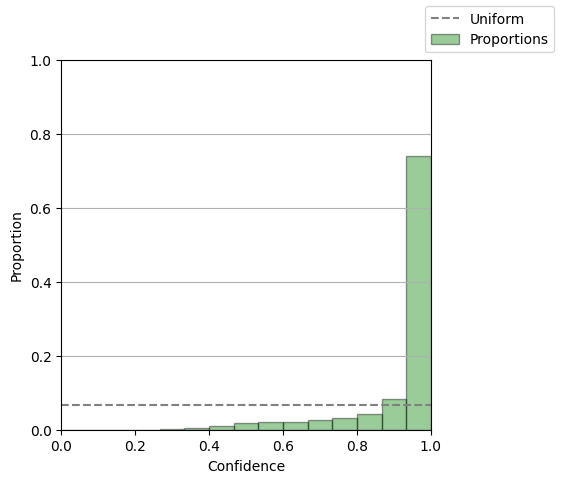

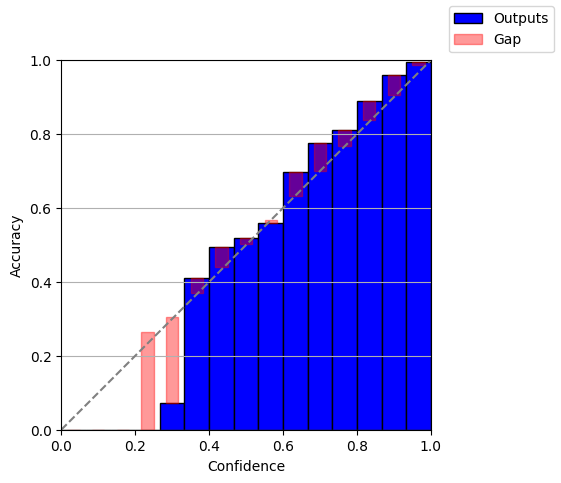

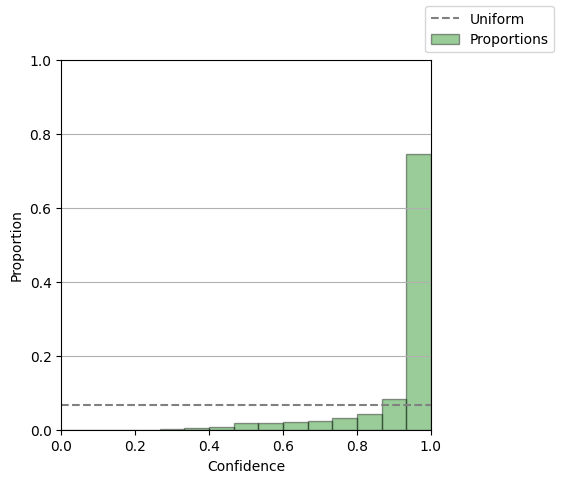

In [19]:
from laplax.eval import apply_fns, evaluate_metrics_on_generator, transfer_entry


def confidences_map(map_, **kwargs):
    del kwargs
    return jnp.max(jax.nn.softmax(map_, axis=-1), axis=-1)


def correctness_map(map_, target, **kwargs):
    del kwargs
    return correctness(pred=map_, target=target).astype(jnp.float32)


def confidences_pred(pred_act, **kwargs):
    del kwargs
    return jnp.max(pred_act, axis=-1)


def correctness_pred(pred_act, target, **kwargs):
    del kwargs
    return correctness(pred=pred_act, target=target).astype(jnp.float32)


results = evaluate_metrics_on_generator(
    pushforward_fn,
    get_test_iter(test_loader),
    metrics=[
        transfer_entry(
            ["pred_mean", "map", "mc_pred_act"]
        ),
        apply_fns(
            confidences_map,
            correctness_map,
            confidences_pred,
            correctness_pred,
            map_="map",
            target="target",
            pred_act="mc_pred_act",
        ),
    ],
    reduce=jnp.concatenate
)

confidences_map = results['confidences_map']
correctness_map = results['correctness_map']
confidences_pred = results['confidences_pred']
correctness_pred = results['correctness_pred']

ece_map = expected_calibration_error(
    confidence=confidences_map, correctness=correctnesses_map, num_bins=NUM_BINS
)
ece_pred = expected_calibration_error(
    confidence=confidences_pred, correctness=correctnesses_pred, num_bins=NUM_BINS
)

print(f"MAP ECE: {ece_map:.4f}")
print(f"MAP acc: {correctnesses_map.mean():.4f}")
print(f"Laplace ECE: {ece_pred:.4f}")
print(f"Laplace acc: {correctnesses_pred.mean():.4f}")
# print(f"Laplace std mean: {std_mean:.4f}")


# Calculate bin metrics for Laplace
bin_proportions_pred, bin_confidences_pred, bin_accuracies_pred = calculate_bin_metrics(
    confidence=confidences_pred, correctness=correctnesses_pred, num_bins=NUM_BINS
)

# Plot the reliability diagram
create_reliability_diagram(
    bin_confidences=bin_confidences_pred,
    bin_accuracies=bin_accuracies_pred,
    num_bins=NUM_BINS,
)

# Plot the proportion diagram
create_proportion_diagram(
    bin_proportions=bin_proportions_pred,
    num_bins=NUM_BINS,
)

# Calculate bin metrics for MAP
bin_proportions_map, bin_confidences_map, bin_accuracies_map = calculate_bin_metrics(
    confidence=confidences_map, correctness=correctnesses_map, num_bins=NUM_BINS
)

# Plot the reliability diagram
create_reliability_diagram(
    bin_confidences=bin_confidences_map,
    bin_accuracies=bin_accuracies_map,
    num_bins=NUM_BINS,
)

# Plot the proportion diagram
create_proportion_diagram(
    bin_proportions=bin_proportions_map,
    num_bins=NUM_BINS,
)